# Modelo *RMFT* ($\sigma$-$\omega$) para la EoS de Estrellas de Neutrones

In [25]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.integrate import odeint, quad
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import fsolve

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

En términos de los campos medios $\sigma$ y $\omega_0$, podemos escribir la densidad de número, la densidad de energía y la presión de la estrella de neutrones como (unidades geometrizadas):

$$ n = \frac{2p_F^3}{3\pi^2\hbar^3} \iff p_F(n) = \left(\frac{3\pi^2\hbar^3 n}{2}\right)^{1/3}$$ 
$$ \rho = \frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F} p^2 \sqrt{p^2 + (m - g_\sigma \sigma)^2} dp$$
$$ P = -\frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 - \frac{2}{3\pi^2\hbar^3} \int_0^{p_F} \frac{p^4}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} dk$$

además, el sistema cumple las ecuaciones de campo:

$$ g_\sigma \sigma = \frac{g_\sigma^2}{m_\sigma^2} \frac{2}{\pi^2 \hbar} \int_0^{p_F} \frac{m - g_\sigma \sigma}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} p^2 dp$$
$$ g_\omega \omega_0 = \frac{g_\omega^2}{m_\omega^2} \hbar^2 n$$

donde $m$ es la masa efectiva de los fermiones, $p_F$ es el momento de Fermi, $g_\sigma$ y $g_\omega$ son las constantes de acoplamiento de los campos $\sigma$ y $\omega$, respectivamente, y $m_\sigma$ y $m_\omega$ son las masas de los campos $\sigma$ y $\omega$. La primera ecuacion presenta un problema de autoconsistencia, ya que $g_\sigma\sigma$ aparece en ambos lados de la ecuación, y puede ser resuelta numéricamente hayando las raices de la ecuación para $g_\sigma \sigma$.  

Ahora bien, tomando $x_\sigma = g_\sigma \sigma$, así como $A_\sigma = \frac{g_\sigma}{m_\sigma}$ y $A_\omega = \frac{g_\omega}{m_\omega}$, podemos reescribir las ecuaciones en términos de las constantes $A_i$ y la densidad bariónica $n$, adimensionalizando las últimas mediante la densidad central $\rho_0$ (mismas unidades de la presión en unidades geometrizadas):

$$ x_\sigma - A_\sigma^2 \frac{2}{\pi^2 \hbar} \int_0^{p_F(n)} \frac{m - x_\sigma}{\sqrt{p^2 + (m - x_\sigma)^2}} p^2 dp = 0$$
$$ \hat\rho = \left[\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F(n)} p^2 \sqrt{p^2 + (m - x_\sigma)^2} dp\right]/\rho_0$$
$$ \hat P = \left[-\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 + \frac{2}{3\pi^2\hbar^3} \int_0^{p_F(n)} \frac{p^4}{\sqrt{p^2 + (m - x_\sigma)^2}} dp\right]/\rho_0$$

Si empleamos las variables $\tilde x_{\sigma} = 1-x_{\sigma}/m$, $\tilde n = (\hbar^3/m^3)n$ y $x = p/m$, y las constantes $\tilde A_{\sigma} = A_{sigma}m/\sqrt{\hbar}$, $\tilde A_{\omega} = A_{\omega}m/\sqrt{\hbar}$ y $\lambda = m^4/\hbar^3$ (la única con dimensiones [$\text{distancia}^{-2}$]), podemos reescribir las ecuaciones adimensionalizadas como: 

$$ 1-\tilde x_{\sigma} - \tilde A_{\sigma}^2 \frac{2}{\pi^2} \int_0^{x_F(n)} \frac{\tilde x_{\sigma}}{\sqrt{x^2 + \tilde x_{\sigma}^2}} x^2 dx = 0$$
$$ \tilde\rho = \frac{\lambda}{2\rho_0} \left[\frac{(1-\tilde x_{\sigma})^2}{\tilde A_{\sigma}^2} + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{\pi^2} \int_0^{x_F(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right]$$
$$ \tilde P = \frac{\lambda}{2\rho_0} \left[-\frac{(1-\tilde x_{\sigma})^2}{\tilde A_{\sigma}^2} + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{3\pi^2} \int_0^{x_F(n)} \frac{x^4}{\sqrt{x^2 + \tilde x_{\sigma}^2}} dx\right]$$


### Solución de la ecuación de autoconsistencia

Utilizamos la función `scipy.optimize.fsolve` para resolver la ecuación de autoconsistencia

In [2]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
m_nuc_MKS = 1.6726219e-27 # kg

# Definimos las constantes necesarias en unidades geometrizadas
hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m

# Damos valores a las constantes (valores tomados del paper de Walecka) (constantes tilde cuadradas)
A_sigma = 266.9
A_omega = 195.7

# Primero la ecuación de autoconsistencia
def autoconsistencia(x_sigma, A_sigma, n_barion):
    x_f = (1.0/m_nuc)*hbar*(3.0*pi**2*n_barion/2.0)**(1/3) # Momento de Fermi en función de n_barion sobre la masa nuclear
    # La integral es analítica
    raiz = np.sqrt(x_f**2+x_sigma**2)
    integral = x_sigma*(x_f*raiz-x_sigma**2*np.arctanh(x_f/raiz))
    return 1.0 - x_sigma - A_sigma*integral/(pi**2)

# Función para resolver la ecuación de autoconsistencia para un n_barion y A_sigma dados
def sol_x_sigma(n_barion, A_sigma):
    solution = fsolve(autoconsistencia, 0.5, args=(A_sigma, n_barion), full_output=True)
    if solution[2] != 1:
        print("No se encontró solución para n_barion = ", n_barion)
        return 0
    else:
        return solution[0][0]

### Interpolación $\rho = \rho(P)$

Usamos el resultado de la ecuación de autoconsistencia para calcular la densidad de energía y la presión

In [3]:
# Definimos las funciones de densidad de energía y presión
def energia_presion(n_barion, A_sigma, A_omega, rho_0, return_x_f=False):
    x_sigma = sol_x_sigma(n_barion, A_sigma)
    x_f = (1.0/m_nuc)*hbar*(3.0*pi**2*n_barion/2.0)**(1/3) # Momento de Fermi sobre la masa nuclear en función de n_barion
    lambda_ = m_nuc**4/hbar**3 # Constante de escala empleada
    
    # Las integrales son analíticas
    raiz = np.sqrt(x_f**2+x_sigma**2)
    termino_arctanh = x_sigma**4*np.arctanh(x_f/raiz)
    
    integral_energia = (x_f*raiz*(2.0*x_f**2+x_sigma**2)-termino_arctanh)/8.0
    integral_presion = (x_f*raiz*(2.0*x_f**2-3.0*x_sigma**2)+3.0*termino_arctanh)/8.0
    
    termino_sigma = (1.0-x_sigma)**2/A_sigma
    termino_omega = 4.0*A_omega*x_f**6/(9.0*pi**4)
    
    energia = (lambda_/(2*rho_0))*(termino_sigma + termino_omega + 4.0/(pi**2)*integral_energia)
    presion = (lambda_/(2*rho_0))*(-termino_sigma + termino_omega + 4.0/(3.0*pi**2)*integral_presion)
    
    if return_x_f:
        return energia, presion, x_f
    else:
        return energia, presion

def EoS(n_barion, A_sigma, A_omega, rho_0, return_presion_cambio=False):
    energias = np.array([])
    presiones = np.array([])
    n_sirve = np.array([])
    
    for n in n_barion:
        energia, presion = energia_presion(n, A_sigma, A_omega, rho_0)
        energias = np.append(energias, energia)
        presiones = np.append(presiones, presion)
        n_sirve = np.append(n_sirve, n)
        
    presion_cambio = 0
    for i in range(len(presiones)-1):
        if presiones[i]<0 and presiones[i+1]>0: # Segundo cambio de signo en la presión
            presion_cambio = i+1
            break
    # print("Presión cambia de negativo a positivo en indice", presion_cambio, "en n_barion =", n_sirve[presion_cambio], ", log10(rho_m) =", np.log10(n_sirve[presion_cambio]*m_nuc_MKS*1e-3), "log10(g/cm^3)")
    
    if return_presion_cambio:
        return CubicSpline(presiones[presion_cambio:], energias[presion_cambio:]), presiones, energias, n_sirve, presion_cambio
    else:
        return CubicSpline(presiones, energias), presiones, energias, n_sirve

### Resultado de la EoS

Visualizamos los resultados de los métodos anteriores

#### Autoconsistencia

x_sigma = 0.008988775080889565 m , x_sigma = 1.2309507300843599e-54 , para n_barion = 5.978637491234571e+46 m^-3, autoconsistencia($\tilde{x}_\sigma$) = 1.1102230246251565e-16


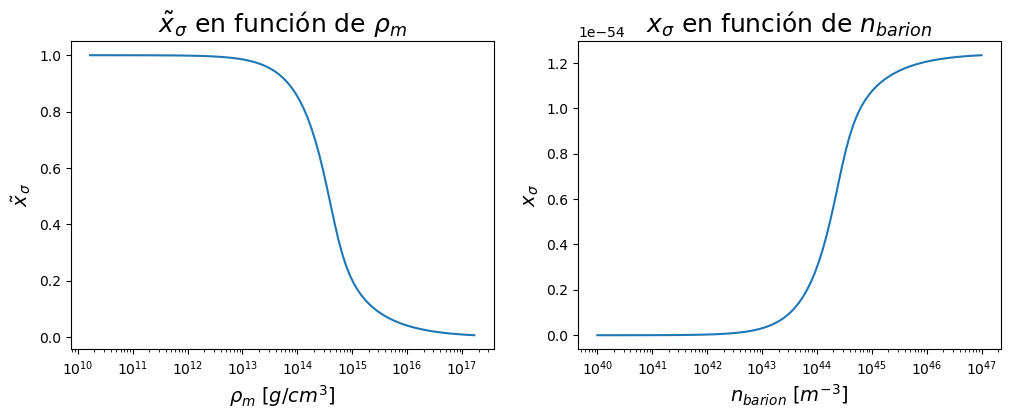

In [ ]:
# Autoconsistencia
n_barion_max = 1e17*1e3/m_nuc_MKS # 1e17 g/cm^3 de bariones en unidades de m^-3
x_sigma = sol_x_sigma(n_barion_max, A_sigma)
x_sigma_norm = (1-x_sigma)*m_nuc # x_sigma no tilde
print("x_sigma =", x_sigma, "m , x_sigma =", x_sigma_norm, ", para n_barion =", n_barion_max, r"m^-3, autoconsistencia($\tilde{x}_\sigma$) =", autoconsistencia(x_sigma, A_sigma, n_barion_max))

# Testeamos la solucion_x_sigma
n_prove = np.logspace(40, 47, 100)
x_sigma_prove_tilde = np.zeros(len(n_prove))
x_sigma_prove = np.zeros(len(n_prove))
for i in range(len(n_prove)):
    x_sigma_prove_tilde[i] = sol_x_sigma(n_prove[i], A_sigma)
    x_sigma_prove[i] = (1-x_sigma_prove_tilde[i])*m_nuc

# Mostramos los resultados para x_sigma y x_sigma en función de n_barion
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(n_prove*m_nuc_MKS*1e-3, x_sigma_prove_tilde)
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\rho_m$ $[g/cm^3]$')
ax[0].set_ylabel(r'$\tilde x_{\sigma}$')
ax[0].set_title(r'$\tilde x_{\sigma}$ en función de $\rho_m$')
ax[1].plot(n_prove, x_sigma_prove)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$n_{barion}$ $[m^{-3}]$')
ax[1].set_ylabel(r'$x_{\sigma}$')
ax[1].set_title(r'$x_{\sigma}$ en función de $n_{barion}$')
plt.show()

#### Valores de  $\frac{B}{A}$ vs $n_{barion}$

Densidad de saturación n_saturacion = 0.19536254832468525 1/fm^3 y energia de enlace por nucleon en saturación = -15.75922435592808 MeV y densidad de energia en saturación = 180.2244652288689 MeV/fm^3


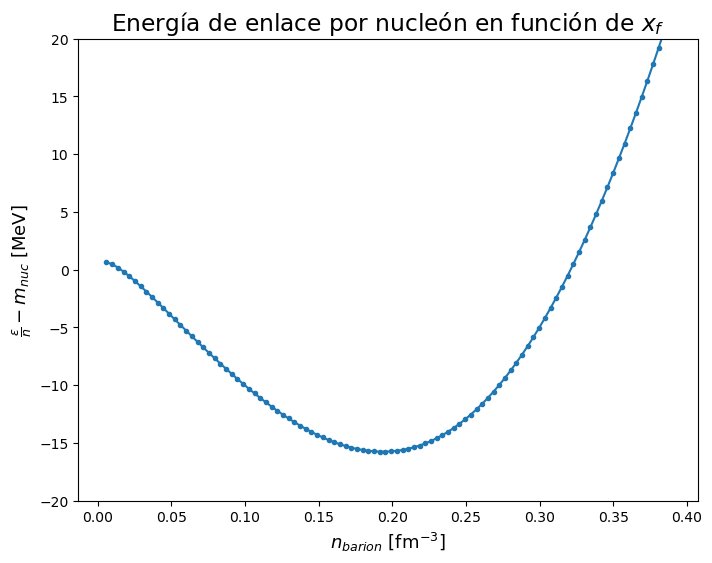

In [13]:
# Graficamos la energia de enlace por nucleon vs el parametro x_f
densidades_prove = np.linspace(1e13, 6.5e14, 100) # Densidades de bariones en g/cm^3
n_prove = densidades_prove*1e3/m_nuc_MKS # Densidades de bariones en m^-3
energias_prove = np.zeros(len(n_prove)) # Energías de enlace por nucleón en m^-2 (geometrizadas)
x_f_prove = np.zeros(len(n_prove)) # Momentos de Fermi adimensional
for i in range(len(n_prove)):
    energias_prove[i], _, x_f_prove[i] = energia_presion(n_prove[i], A_sigma, A_omega, 1, True)
    
# Hallamos la densidad de saturación en fm^-3 a partir del x_f donde es minima la energía de enlace por nucleón
e_MKS = 1.6021766e-19 # J
minimo = np.argmin(energias_prove/n_prove - m_nuc)
n_saturacion = n_prove[minimo] # Densidad de saturación en m^-3
n_saturacion *= (1e-15)**3 # Densidad de saturación en fm^-3
print("Densidad de saturación n_saturacion =", n_saturacion, "1/fm^3 y energia de enlace por nucleon en saturación =", (np.min(energias_prove/n_prove - m_nuc))*c_MKS**4/G_MKS/e_MKS*1e-6, "MeV y densidad de energia en saturación =", energias_prove[minimo]*c_MKS**4/G_MKS/e_MKS*1e-6*(1e-15)**3, "MeV/fm^3")
    
# Graficamos la energía de enlace por nucleón en función de x_f
plt.figure(figsize=(8,6))
plt.plot(n_prove*(1e-15)**3, (energias_prove/n_prove - m_nuc)*c_MKS**4/G_MKS/e_MKS*1e-6, "-o")
# plt.plot(n_prove*(1e-15)**3, (energias_prove/n_prove - m_nuc)*c_MKS**4/G_MKS/e_MKS*1e-6, "-o")
plt.xlabel(r'$n_{barion}$ [fm$^{-3}$]')
plt.ylabel(r'$\frac{\epsilon}{n}-m_{nuc}$ [MeV]')
plt.ylim(-20, 20)
plt.title(r'Energía de enlace por nucleón en función de $x_f$')
plt.show()

#### Interpolación de la ecuación de estado

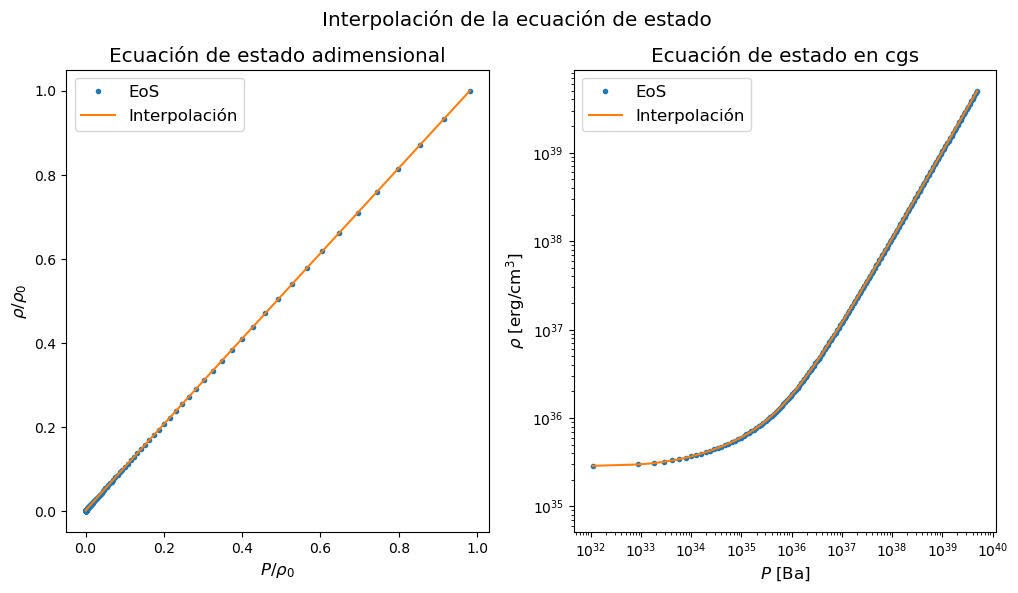

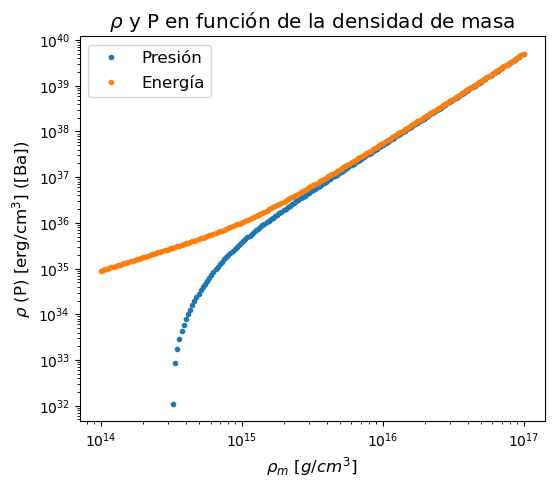

In [26]:
# Calculamos la densidad de energía central para una densidad barionica de 1e47
densidad_masa_max = 1e17*1e3 # g/cm^3 a kg/m^3
densidad_masa_min = 1e14*1e3 # g/cm^3 a kg/m^3
n_barion_max = densidad_masa_max/m_nuc_MKS # m^-3
n_barion_min = densidad_masa_min/m_nuc_MKS # m^-3

rho_0, _ = energia_presion(n_barion_max, A_sigma, A_omega, 1)
# print("Densidad central = ", rho_0, "para n_barion_max = ", n_barion_max)

# Definimos el rango de densidades barionicas e interpolamos la ecuación de estado
n_barion = np.logspace(np.log10(n_barion_min), np.log10(n_barion_max), 200)
rho_P, presiones, energias, n_sirve, presion_cambio = EoS(n_barion, A_sigma, A_omega, rho_0, return_presion_cambio=True)

# Graficamos la ecuación de estado rho(P)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#Adimensional
ax1.plot(presiones, energias, "o", label='EoS')
ax1.plot(presiones, rho_P(presiones), label='Interpolación')
ax1.set_xlabel(r'$P/\rho_0$')
ax1.set_ylabel(r'$\rho/\rho_0$')
ax1.set_title('Ecuación de estado adimensional')
ax1.legend()

#MKS
rho_geoToMKS = c_MKS**4/G_MKS # factor de conversión de densidad de energía y presión de unidades geométricas a MKS
rho_MKSTocgs = 10 # factor de conversión de densidad de energía y presión de unidades MKS a cgs
ax2.loglog(presiones*rho_0*rho_geoToMKS*rho_MKSTocgs, energias*rho_0*rho_geoToMKS*rho_MKSTocgs, "o", label='EoS')
ax2.loglog(presiones[presion_cambio:]*rho_0*rho_geoToMKS*rho_MKSTocgs, rho_P(presiones[presion_cambio:])*rho_0*rho_geoToMKS*rho_MKSTocgs, label='Interpolación')
ax2.set_xlabel(r'$P$ [Ba]')
ax2.set_ylabel(r'$\rho$ [erg/cm$^3$]')
ax2.set_title('Ecuación de estado en cgs')
ax2.legend()

plt.suptitle('Interpolación de la ecuación de estado')
plt.show()

# Graficamos presión y energía en función de n_barion
plt.figure(figsize=(6, 5))
plt.loglog(n_sirve*m_nuc_MKS*1e-3, presiones*rho_0*rho_geoToMKS*rho_MKSTocgs, "o", label='Presión')
plt.loglog(n_sirve*m_nuc_MKS*1e-3, energias*rho_0*rho_geoToMKS*rho_MKSTocgs, "o", label='Energía')
plt.xlabel(r'$\rho_m$ $[g/cm^3]$')
plt.ylabel(r'$\rho$ (P) [erg/cm$^3$] ([Ba])')
plt.title(r'$\rho$ y P en función de la densidad de masa')
plt.legend()
plt.show()

## Solución de las ecuaciones hidrostáticas

### Definición de los sistemas, funciones e integrador

In [ ]:
# Definimos una función para convertir las cantidades adimensionales a cantidades físicas
# la adimensionalización es identica en Newton y en GR
def adimensional_to_fisico(sol_fin, P_central, r_fin, rho0):
    P, m, phi, rho = sol_fin
    
    # Obtenemos las constantes de adimensionalización
    P0 = rho0
    R = np.sqrt(c_MKS**4/(4*pi*G_MKS*rho0))
    M = 4*pi*R**3*rho0/c_MKS**2

    # Convertimos las cantidades adimensionales a cantidades físicas
    P_fisico = P0*P_central
    m_fisico = M*m
    phi_fisico = phi
    rho_fisico = rho0
    r_fisico = R*r_fin

    # P y rho finales
    # P_final = P0*P
    # rho_final = rho0*rho

    return [r_fisico, m_fisico, rho_fisico, P_fisico, phi_fisico]

# Definimos el sistema de ecuaciones newtonianas
def newtonianas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2
    dphi_dr = m/r**2

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos el sistema de ecuaciones GR
def relativistas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
    dphi_dr = -dP_dr/(rho + P)

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos la función que integre y recupere las cantidades fisicas para un valor de rho0 y un sistema de ecuaciones dado
def integrador(rf, dr, rho0_masa, sistema, sol_completa = False):
    # Malla de integración para ambos sistemas
    N = int(rf/dr) # Número de puntos
    r = np.linspace(dr, rf, N) # Puntos de integración

    # Interpolamos la ecuación de estado para obtener rho(P)
    # Calculamos la densidad de energía central para densidades de masa de 1e11 a 1e17
    densidad_masa_max = 1e17*1e3 # g/cm^3 a kg/m^3
    densidad_masa_min = 1e14*1e3 # g/cm^3 a kg/m^3
    # densidad_masa_min = 0
    n_barion_max = densidad_masa_max/m_nuc_MKS # m^-3
    n_barion_min = densidad_masa_min/m_nuc_MKS # m^-3
    n_barion = np.logspace(np.log10(n_barion_min), np.log10(n_barion_max), 250)
    rho_0, _ = energia_presion(rho0_masa*1e3/m_nuc_MKS, A_sigma, A_omega, 1) # Densidad central de energía en unidades geométricas
    # rho_0 = m_nuc**4/hbar**3/2 # Lambda/(2*rho_0) = 1
    rho0 = rho_0*c_MKS**4/G_MKS # Densidad central de energía en MKS
    rho_P, presiones, energias, n_sirve, presion_cambio = EoS(n_barion, A_sigma, A_omega, rho_0, return_presion_cambio=True)
    presiones = presiones[presion_cambio:]
    energias = energias[presion_cambio:]
    P_central = CubicSpline(energias, presiones)(energias[-1]) # Presion central adimensional
    
    # Definimos las condiciones iniciales en r = dr (para evitar la singularidad en r = 0)
    # estas son cantidades adimensionales, así que rho(0) = 1 y m(0) = 0
    rhoc = 1.0
    m0 = rhoc*dr**3/3 # m = 0 + 0r + 0r^2/2 + 2rho(0)r^3/6 ...
    
    if sistema == 'newtoniano':
        ecuaciones = newtonianas
        P0 = P_central- rhoc * dr**2 / 6.0
        phi0 = 1 + rhoc**2*dr**2/6
    elif sistema == 'relativista':
        ecuaciones = relativistas
        P0 = P_central- ( 3.0*P_central**2 + 4.0*P_central*rhoc + rhoc**2)*dr**2/6.0
        phi0 = 1 + ( rhoc/3.0 + P_central ) * dr**2 / 2.0

    # Resolvemos el sistema de ecuaciones
    sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T

    # Obtenemos la densidad a partir de las presiones
    P, m, phi = sol
    rho = rho_P(P)

    # Buscamos el radio donde la densidad es cero
    lim = len(r)-1
    densidad_limite = 1e11*1e3 # g/cm^3 a kg/m^3
    densidad_limite = densidad_limite/m_nuc_MKS # m^-3
    # la condicion para el limite de nuestra estrella es la densidad definida por densidad_limite
    for i in range(len(r)):
        if rho[i] <= densidad_limite:
            lim = i-1
            break
    # print("Radio de la estrella: ", r[lim], " en el paso ", lim, " de ", N)

    # Obtenemos las cantidades finales
    sol_fin = [P[lim], m[lim], phi[lim], rho[lim]]

    if sol_completa:
        return adimensional_to_fisico(sol_fin, P_central, r[lim], rho0), np.append(sol[:, :lim], [rho[:lim]], axis=0), r[:lim]
    else:
        # Convertimos las cantidades adimensionales a cantidades físicas
        return adimensional_to_fisico(sol_fin, P_central, r[lim], rho0)

# Malla de integración para ambos sistemas
rf = 50 # Radio adimensional final
dr = 1e-3 # Paso de integración

### Relación Masa Radio y Masa Densidad Central

In [14]:
# Definimos el rango de densidades de masa para el cual queremos integrar
rhos = np.linspace(14, 18, 50)
rhos = np.power(10, rhos)

# Integramos para cada densidad de masa
masas_N  = np.array([])
radios_N = np.array([])
masas_R  = np.array([])
radios_R = np.array([])

for rho in rhos:
    sol_N    = integrador(rf, dr, rho, 'newtoniano')
    sol_R    = integrador(rf, dr, rho, 'relativista')
    masas_N  = np.append(masas_N, sol_N[1])
    radios_N = np.append(radios_N, sol_N[0])
    masas_R  = np.append(masas_R, sol_R[1])
    radios_R = np.append(radios_R, sol_R[0])

Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)


C:\Users\nicom\AppData\Local\Temp\ipykernel_8148\1903031914.py:93: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T


Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)
Presión cambia de negativo a posit

1.9553440497534165


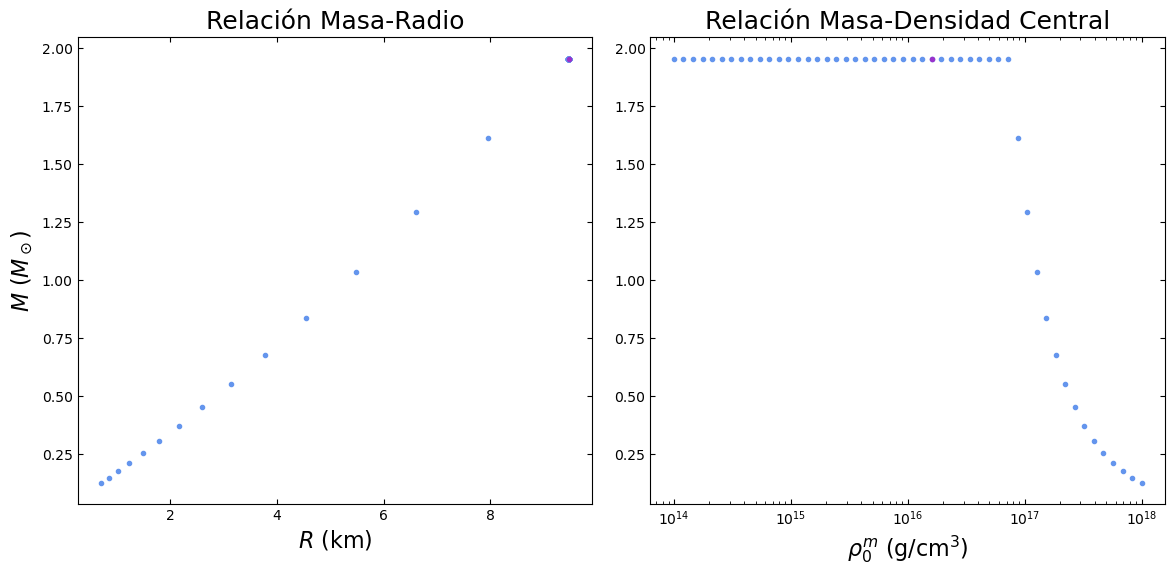

In [15]:
# Graficamos las relaciones masa radio y masa densidad en masas solares
masasolar=1.989e30
color = "cornflowerblue"
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].loglog(radios_N/1e3, masas_N/masasolar, label='Newtoniano')
# ax[0].loglog(radios_R/1e3, masas_R/masasolar, label='Relatividad General')
# ax[0].legend()
ax[0].plot(radios_R/1e3, masas_R/masasolar, 'o', color=color, linewidth=2)
ax[0].set_xlabel(r'$R$ (km)', fontsize=16)
ax[0].set_ylabel(r'$M$ ($M_\odot$)', fontsize=16)
ax[0].set_title(r'Relación Masa-Radio', fontsize=18)
ax[0].tick_params(axis='both', which='both', direction='in', right=True, top=True)
#Punto en la masa maxima
ax[0].plot(radios_R[np.argmax(masas_R)]/1e3, masas_R.max()/masasolar, 'o', color='darkorchid')

# ax[1].loglog(rhos, masas_N/masasolar, label='Newtoniano')
# ax[1].loglog(rhos, masas_R/masasolar, label='Relatividad General')
# ax[1].legend()
ax[1].semilogx(rhos, masas_R/masasolar, 'o', color=color, linewidth=2)
ax[1].set_xlabel(r'$\rho_0^m$ (g/cm$^3$)', fontsize=16)
# ax[1].set_ylabel(r'$M$ ($M_\odot$)')
ax[1].set_title(r'Relación Masa-Densidad Central', fontsize=18)
ax[1].tick_params(axis='both', which='both', direction='in', right=True, top=True)
#Punto en la masa maxima
ax[1].plot(rhos[np.argmax(masas_R)], masas_R.max()/masasolar, 'o', color='darkorchid')

print(masas_R.max()/masasolar)

plt.tight_layout()
plt.show()

### Sistema GR con la masa máxima

Presión cambia de negativo a positivo en indice 43 en n_barion = 1.9709450230086916e+44 , log10(rho_m) = 14.518072289156626 log10(g/cm^3)


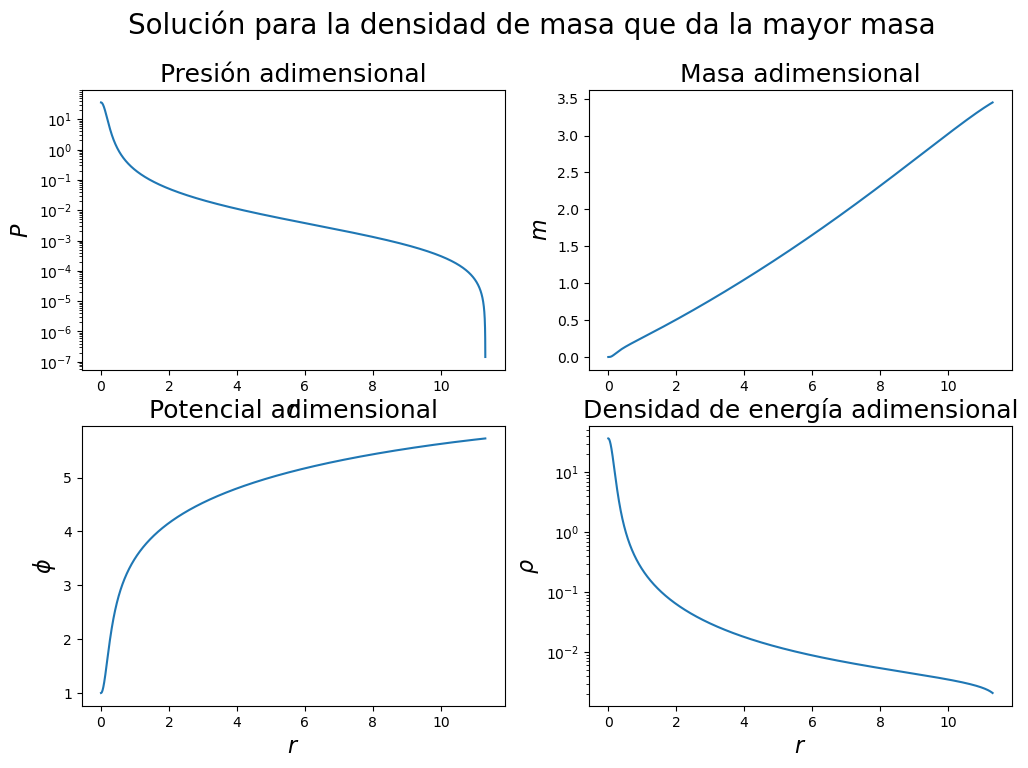

In [16]:
# Integramos para la densidad de masa que da la mayor masa
sol_final, sol_masa_max_R, r = integrador(rf, dr, rhos[np.argmax(masas_R)], 'relativista', sol_completa=True)

# Obtenemos la densidad a partir de las presiones
P_R, m_R, phi_R, rho_R = sol_masa_max_R

# Graficamos las soluciones
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].semilogy(r, P_R, label=r'$P$')
ax[0, 0].set_xlabel(r'$r$', fontsize=16)
ax[0, 0].set_ylabel(r'$P$', fontsize=16)
ax[0, 0].set_title(r'Presión adimensional', fontsize=18)

ax[0, 1].plot(r, m_R, label=r'$m$')
ax[0, 1].set_xlabel(r'$r$', fontsize=16)
ax[0, 1].set_ylabel(r'$m$', fontsize=16)
ax[0, 1].set_title(r'Masa adimensional', fontsize=18)

ax[1, 0].plot(r, phi_R, label=r'$\phi$')
ax[1, 0].set_xlabel(r'$r$', fontsize=16)
ax[1, 0].set_ylabel(r'$\phi$', fontsize=16)
ax[1, 0].set_title(r'Potencial adimensional', fontsize=18)

ax[1, 1].semilogy(r, rho_R, label=r'$\rho$')
ax[1, 1].set_xlabel(r'$r$', fontsize=16)
ax[1, 1].set_ylabel(r'$\rho$', fontsize=16)
ax[1, 1].set_title(r'Densidad de energía adimensional', fontsize=18)

# plt.tight_layout()
plt.suptitle('Solución para la densidad de masa que da la mayor masa', fontsize=20)
plt.show()

In [ ]:
import ResolverTOV as TOV
import numpy as np

# Obtenemos la ecuacion de estado de gas de neutrones
rho_P, rho0, P_central = TOV.gas_neutrones(1e15, extrapolate=True)

# Integramos
# TOV.graficar_solucion(50, 1e-3, rho0, rho_P, P_central)

# Masa Radio
rhos = np.linspace(14, 17, 50)
TOV.masa_radio(50, 1e-3, , rho_P, P_central, densidades_plot=np.power(10, rhos))

c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\ResolverTOV.py:139: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T


(array([3.95369388e+14, 3.59904033e+14, 3.27619986e+14, 2.98231876e+14,
        2.71479933e+14, 2.47127689e+14, 2.24959885e+14, 2.04780573e+14,
        1.86411383e+14, 1.69689942e+14, 1.54468445e+14, 1.40612344e+14,
        1.27999161e+14, 1.16517403e+14, 1.06065579e+14, 9.65513036e+13,
        8.78904758e+13, 8.00065400e+13, 7.28298076e+13, 6.62968411e+13,
        6.03498937e+13, 5.49363983e+13, 5.00085032e+13, 4.55226494e+13,
        4.14391848e+13, 3.77220144e+13, 3.43382810e+13, 3.12580746e+13,
        2.84541684e+13, 2.59017776e+13, 2.35783410e+13, 2.14633208e+13,
        1.95380219e+13, 1.77854257e+13, 1.61900406e+13, 1.47377645e+13,
        1.34157601e+13, 1.22123420e+13, 1.11168727e+13, 1.01196689e+13,
        9.21191620e+12, 8.38559054e+12, 7.63338779e+12, 6.94865899e+12,
        6.32535162e+12, 5.75795606e+12, 5.24145691e+12, 4.77128867e+12,
        4.34329539e+12, 3.95369388e+12]),
 array([3.90441846e+40, 3.55418501e+40, 3.23536814e+40, 2.94514972e+40,
        2.68096443e+40